# Predict Student Performance From Game Play

Currently on-going Kaggle challenge: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion?search=questions

#### Goal: Use machine learning algorithm to predict how student's will do on in game quiz based on actions taken on levels before the quiz.

This notebook will cover the general strategies taken in preprocessing data in a structured, storied format so as to understand the flow and thought proccess underwent during the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
from xgboost import XGBClassifier

## Load in train data

train data loaded in chunks to avoid memory issue. taken from: https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-680?scriptVersionId=123110383

In [2]:
PATH = "../../../../data-mining-file/"

In [3]:
# READ USER ID ONLY
tmp = pd.read_csv(PATH+"train.csv",usecols=[0])
tmp = tmp.groupby('session_id').session_id.agg('count')

# COMPUTE READS AND SKIPS
PIECES = 10
CHUNK = int( np.ceil(len(tmp)/PIECES) )

reads = []
skips = [0]
for k in range(PIECES):
    a = k*CHUNK
    b = (k+1)*CHUNK
    if b>len(tmp): b=len(tmp)
    r = tmp.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1]+r)
    
print(f'To avoid memory error, we will read train in {PIECES} pieces of sizes:')
print(reads)


To avoid memory error, we will read train in 10 pieces of sizes:
[2684191, 2631991, 2638304, 2657670, 2644229, 2629801, 2596616, 2602258, 2619995, 2591891]


## Data Exploration/Understanding

In [4]:
train = pd.read_csv(PATH+'train.csv', nrows=reads[0])
train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [5]:
targets = pd.read_csv(PATH+'train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
targets.head()

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


Description of variables (taken directly from Kaggle):
- session_id: the ID of the session the event took place in
- index: the index of the event for the session
- elapsed_time: how much time has passed (in milliseconds) between the start of the session and when the event was recorded
- event_name: the name of the event type
- name: the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
- level: what level of the game the event occurred in (0 to 22)
- page: the page number of the event (only for notebook-related events)
- room_coor_x: the coordinates of the click in reference to the in-game room (only for click events)
- room_coor_y: the coordinates of the click in reference to the in-game room (only for click events)
- screen_coor_x: the coordinates of the click in reference to the player’s screen (only for click events)
- screen_coor_y: the coordinates of the click in reference to the player’s screen (only for click events)
- hover_duration: how long (in milliseconds) the hover happened for (only for hover events)
- text: the text the player sees during this event
- fqid: the fully qualified ID of the event
- room_fqid: the fully qualified ID of the room the event took place in
- text_fqid: the fully qualified ID of the
- fullscreen: whether the player is in fullscreen mode
- hq: whether the game is in high-quality
- music: whether the game music is on or off
- level_group: which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

Questions per level group: 1-3, 4-13, 14-18

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2684191 entries, 0 to 2684190
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      int64  
 17  hq              int64  
 18  music           int64  
 19  level_group     object 
dtypes: float64(6), int64(7), object(7)
memory usage: 409.6+ MB


In [7]:
train.isnull().sum()

session_id              0
index                   0
elapsed_time            0
event_name              0
name                    0
level                   0
page              2624828
room_coor_x        229796
room_coor_y        229796
screen_coor_x      229796
screen_coor_y      229796
hover_duration    2461498
text              1721836
fqid               844526
room_fqid               0
text_fqid         1721829
fullscreen              0
hq                      0
music                   0
level_group             0
dtype: int64

In [8]:
for var in train.columns:
    print(var, pd.unique(train[var]))

session_id [20090312431273200 20090312433251036 20090312455206810 ...
 20110316212201948 20110316284487930 20110316334583480]
index [    0     1     2 ... 20471 20472 20473]
elapsed_time [      0    1323     831 ... 1771651 1773335 1773917]
event_name ['cutscene_click' 'person_click' 'navigate_click' 'observation_click'
 'notification_click' 'object_click' 'object_hover' 'map_hover'
 'map_click' 'checkpoint' 'notebook_click']
name ['basic' 'undefined' 'close' 'open' 'prev' 'next']
level [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
page [nan  0.  1.  3.  4.  5.  6.  2.]
room_coor_x [-413.99140522 -412.99140522  478.48507949 ...  157.68814223  181.13604247
  180.50771073]
room_coor_y [-159.31468617 -157.31468617 -199.97167874 ...   35.00568864   24.62705761
   -0.88677916]
screen_coor_x [380.         381.         593.         ... 331.78527832  25.26841545
 426.2671814 ]
screen_coor_y [494.         492.         485.         ... 314.12426758 632.87524414
 252.5723

room_fqid ['tunic.historicalsociety.closet' 'tunic.historicalsociety.basement'
 'tunic.historicalsociety.entry' 'tunic.historicalsociety.collection'
 'tunic.historicalsociety.stacks' 'tunic.kohlcenter.halloffame'
 'tunic.capitol_0.hall' 'tunic.historicalsociety.closet_dirty'
 'tunic.historicalsociety.frontdesk' 'tunic.humanecology.frontdesk'
 'tunic.drycleaner.frontdesk' 'tunic.library.frontdesk'
 'tunic.library.microfiche' 'tunic.capitol_1.hall'
 'tunic.historicalsociety.cage' 'tunic.historicalsociety.collection_flag'
 'tunic.wildlife.center' 'tunic.flaghouse.entry' 'tunic.capitol_2.hall']
text_fqid ['tunic.historicalsociety.closet.intro'
 'tunic.historicalsociety.closet.gramps.intro_0_cs_0'
 'tunic.historicalsociety.closet.teddy.intro_0_cs_0' nan
 'tunic.historicalsociety.closet.teddy.intro_0_cs_5'
 'tunic.historicalsociety.closet.photo'
 'tunic.historicalsociety.closet.notebook'
 'tunic.historicalsociety.closet.retirement_letter.hub'
 'tunic.historicalsociety.basement.janitor'
 'tun

# Feature Engineering
#### features from https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-680?scriptVersionId=123110383

In [9]:
categorical_vars = ['event_name', 'fqid', 'room_fqid', 'text']
numerical_vars = ['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']
events = ['navigate_click', 'person_click', 'cutscene_click', 'object_click','map_hover','notification_click','map_click','observation_click','checkpoint']

In [10]:
def feature_engineer(train):
    
    dfs = []
    for c in categorical_vars:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in numerical_vars:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in numerical_vars:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in events: 
        train[c] = (train.event_name == c).astype('int8')
    for c in events + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(events,axis=1)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [11]:
# PROCESS TRAIN DATA IN PIECES
all_pieces = []
print(f'Processing train as {PIECES} pieces to avoid memory error... ')
for k in range(PIECES):
    print(k,', ',end='')
    SKIPS = 0
    if k>0: SKIPS = range(1,skips[k]+1)
    train = pd.read_csv(PATH+'train.csv',
                        nrows=reads[k], skiprows=SKIPS)
    all_pieces.append(train)
    
# CONCATENATE ALL PIECES

Processing train as 10 pieces to avoid memory error... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

In [12]:
df = pd.concat(all_pieces, axis=0)
df = feature_engineer(df)
# del train;
df

,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,-1.000000,7.701275,-71.413749,...,81,22,28,11,4,8,2,4,1,14155937
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,-1.000000,-130.347170,-162.004310,...,170,123,60,20,14,10,6,3,1,437052322
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,-1.000000,14.306062,-57.269322,...,103,104,12,28,9,9,8,1,1,105732736
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,0.000000,-84.045960,-53.671082,...,49,18,36,15,3,5,3,2,1,13571045
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,5.100000,-30.762282,-142.861892,...,637,145,65,83,186,14,45,5,1,3241011333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100219442786200,13-22,11,49,12,166,9.619192e+05,17.671395,5.230769,-158.599129,-257.988796,...,181,101,54,15,13,8,8,5,1,406891805
22100219442786200,5-12,11,41,11,116,3.866058e+05,8.111511,1.833333,-2.569202,-96.365247,...,85,95,11,23,10,9,7,1,1,107476420
22100221145014656,0-4,11,27,7,64,2.036104e+05,2.061611,0.333333,-1.339605,-39.749052,...,92,27,31,27,2,9,2,5,1,42961793


In [152]:
df.to_csv(PATH+"train_df_eng.csv",index=True)

In [155]:
train_df_eng = pd.read_csv(PATH+"train_df_eng.csv")
train_df_eng=train_df_eng.set_index("session_id")

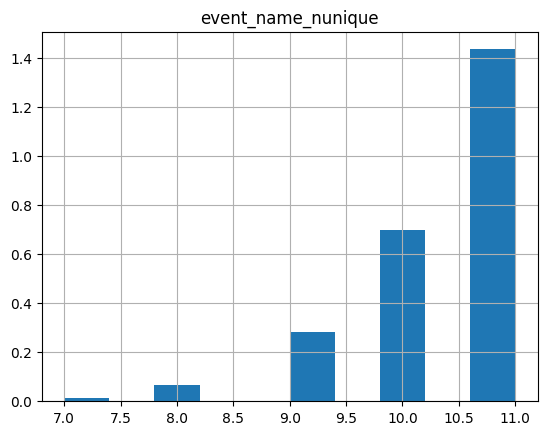

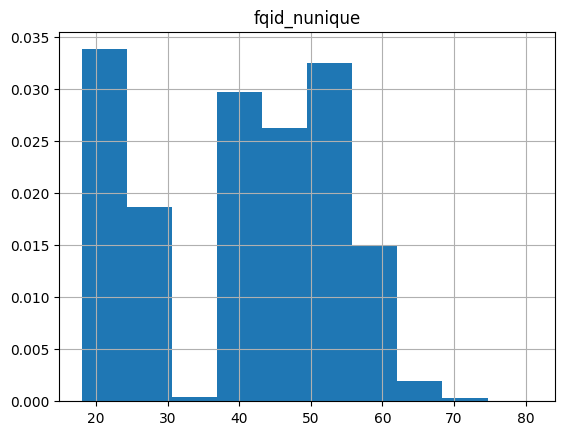

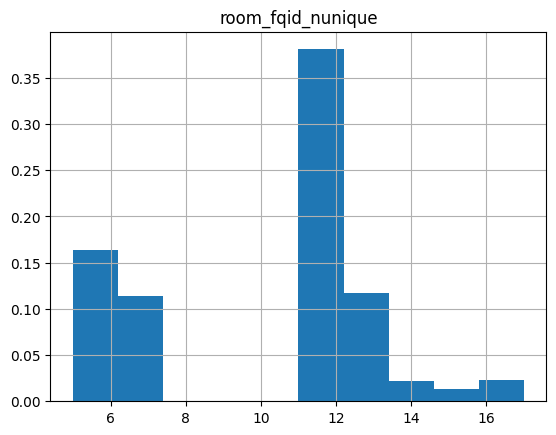

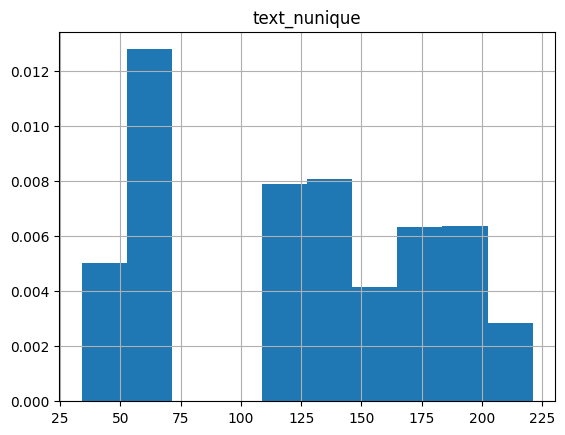

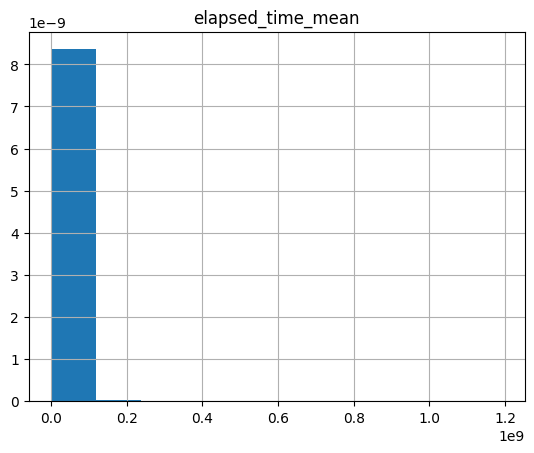

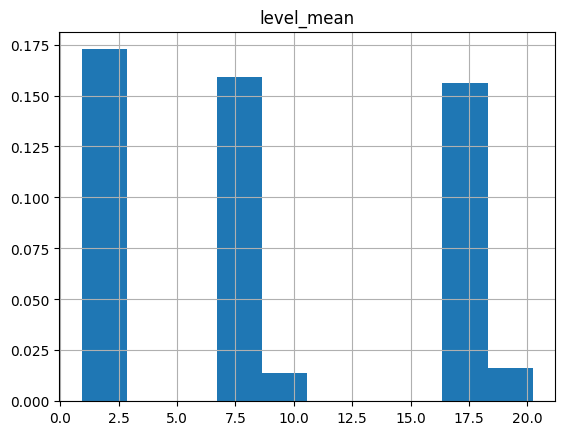

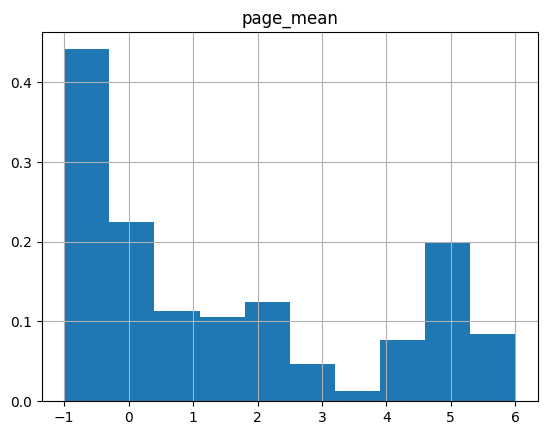

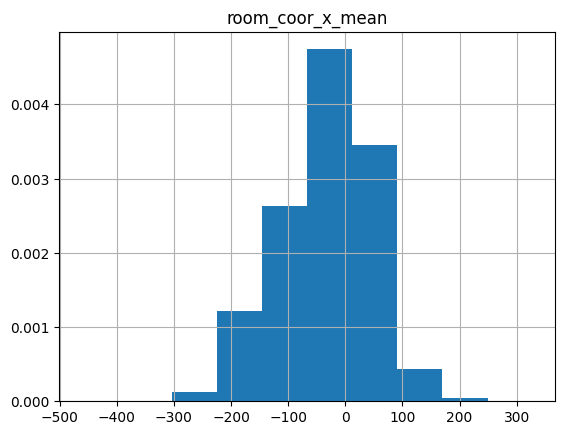

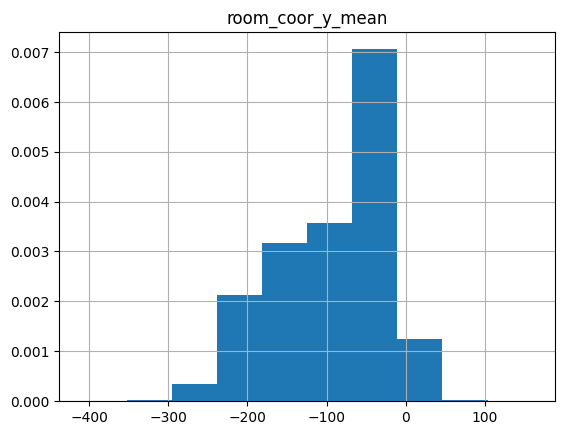

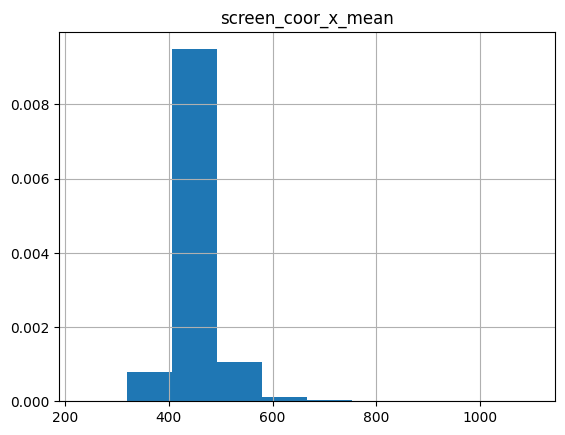

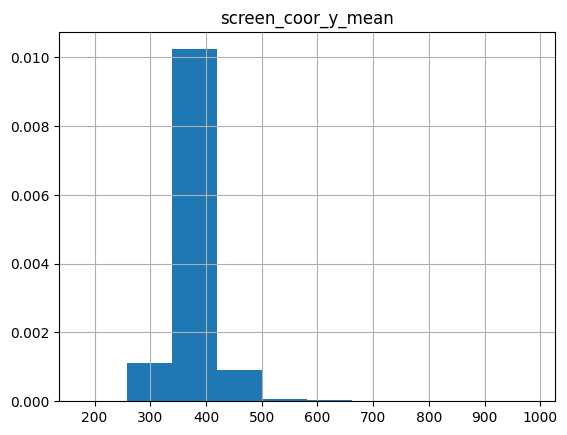

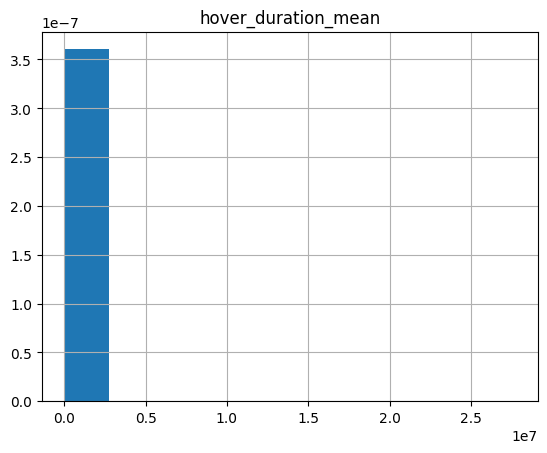

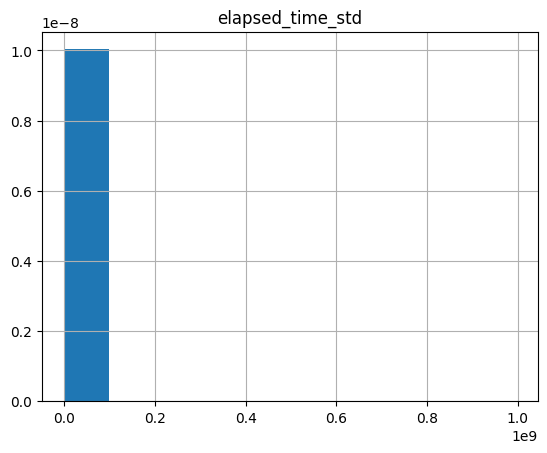

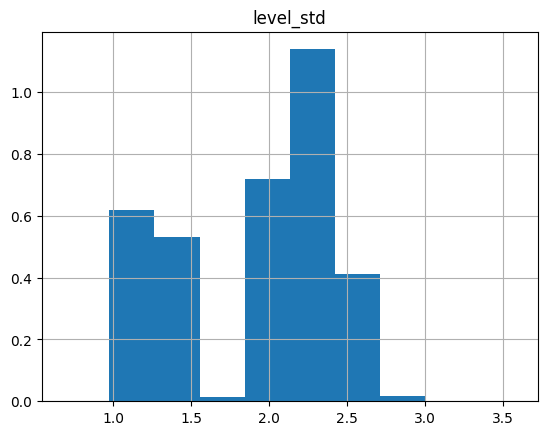

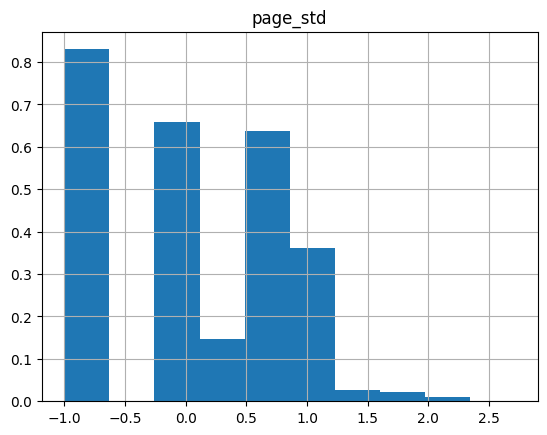

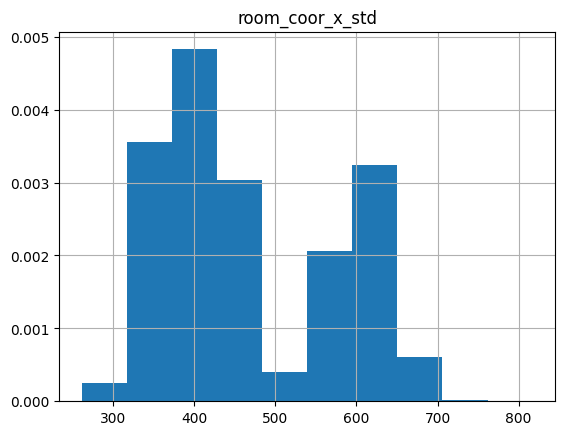

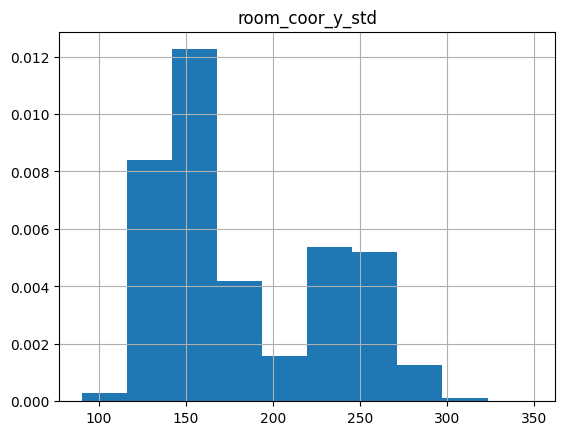

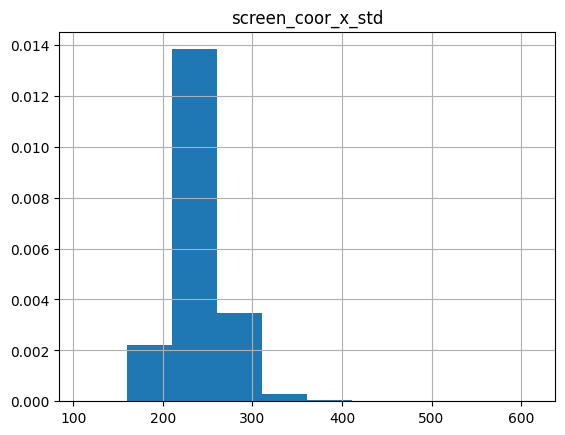

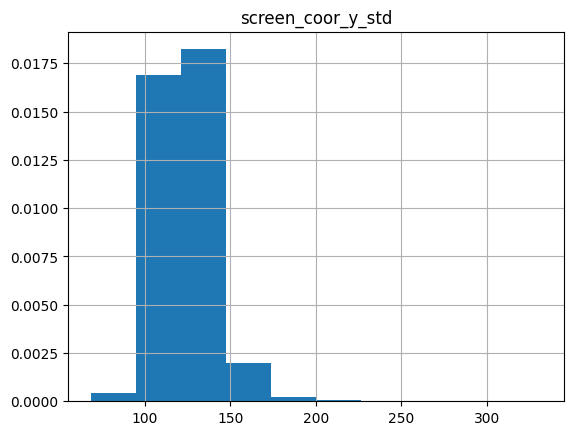

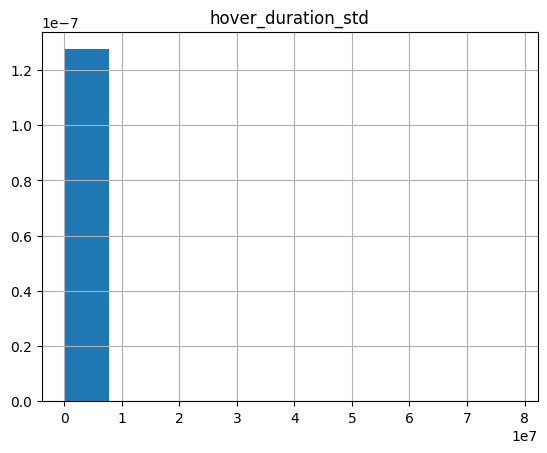

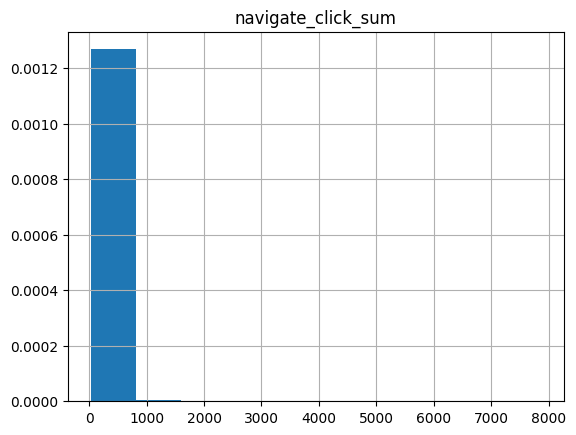

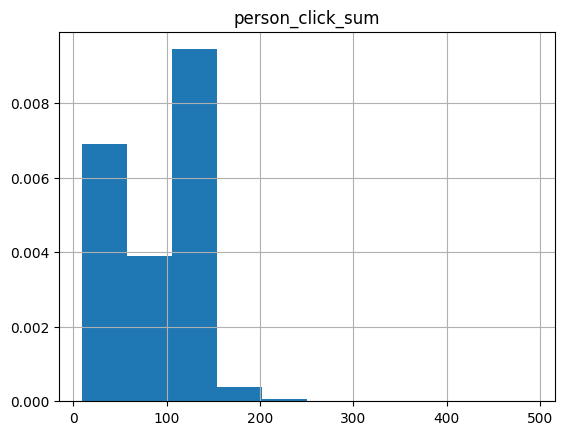

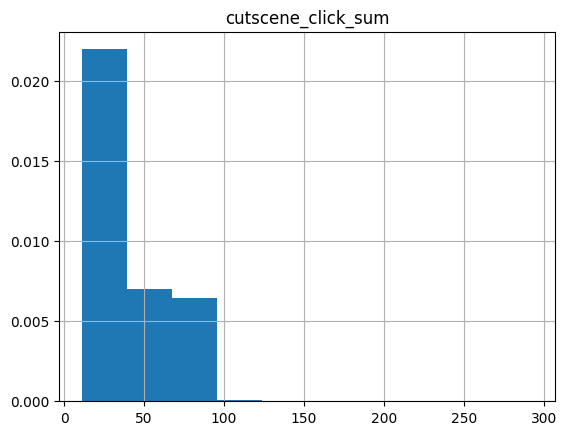

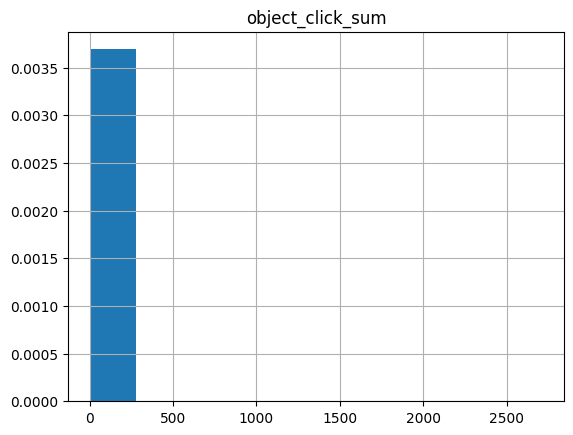

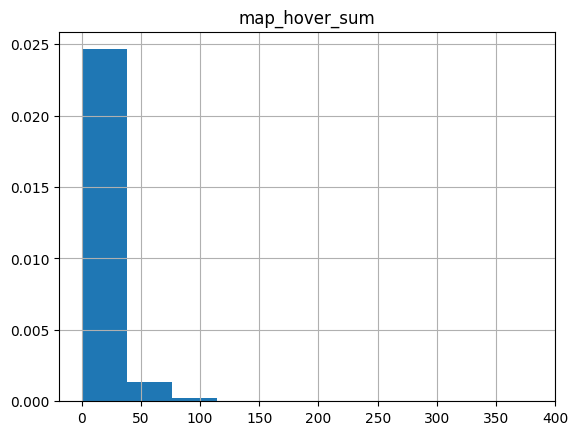

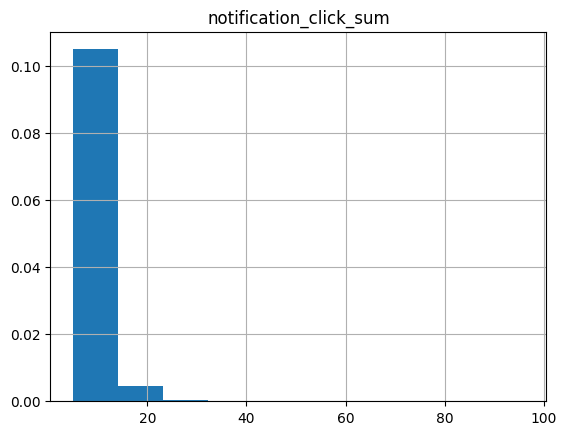

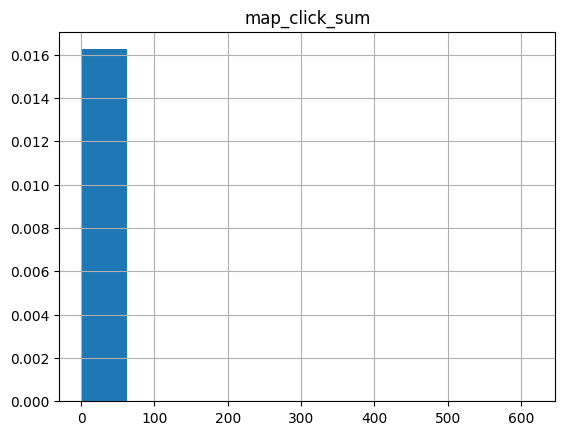

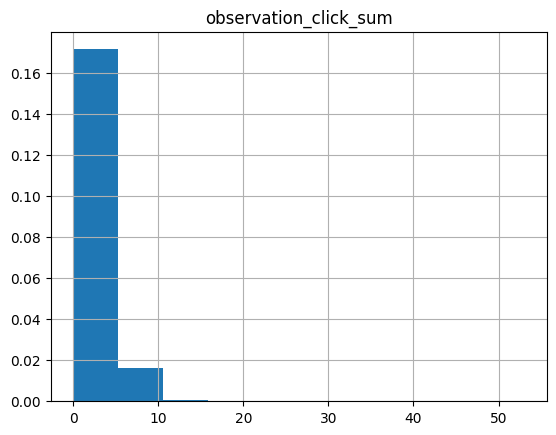

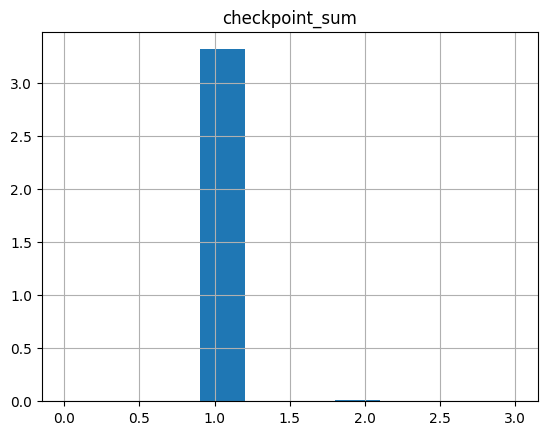

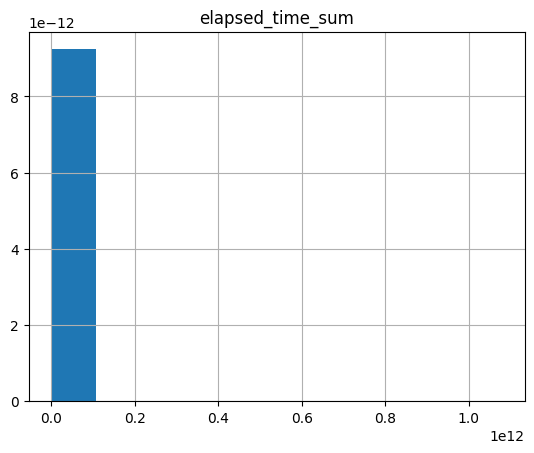

In [14]:
names = train_df_eng.drop("level_group", axis=1).columns
for name in names:
    train_df_eng.drop(["level_group"],axis=1)[name].hist(density=True)
    plt.title(name)
    plt.show()

In [15]:
train_df_eng.isnull().sum()

level_group               0
event_name_nunique        0
fqid_nunique              0
room_fqid_nunique         0
text_nunique              0
elapsed_time_mean         0
level_mean                0
page_mean                 0
room_coor_x_mean          0
room_coor_y_mean          0
screen_coor_x_mean        0
screen_coor_y_mean        0
hover_duration_mean       0
elapsed_time_std          0
level_std                 0
page_std                  0
room_coor_x_std           0
room_coor_y_std           0
screen_coor_x_std         0
screen_coor_y_std         0
hover_duration_std        0
navigate_click_sum        0
person_click_sum          0
cutscene_click_sum        0
object_click_sum          0
map_hover_sum             0
notification_click_sum    0
map_click_sum             0
observation_click_sum     0
checkpoint_sum            0
elapsed_time_sum          0
dtype: int64

## First Attempt at scaling using Min/Max

In [16]:
train_df_eng_temp = train_df_eng.drop('level_group', axis=1)
train_df_eng_temp = (train_df_eng_temp-train_df_eng_temp.min())/(train_df_eng_temp.max()-train_df_eng_temp.min())
train_df_eng_adj = pd.concat([train_df_eng.level_group, train_df_eng_temp],axis=1)

In [17]:
train_df_eng_adj

,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,0.75,0.190476,0.166667,0.117647,0.000072,0.052961,0.000000,0.594199,0.593100,...,0.007137,0.026915,0.060284,0.001850,0.010499,0.032967,0.001626,0.075472,0.333333,0.000013
20090312431273200,13-22,0.75,0.492063,0.583333,0.716578,0.000873,0.853891,0.000000,0.419352,0.434052,...,0.018481,0.236025,0.173759,0.005179,0.036745,0.054945,0.008130,0.056604,0.333333,0.000405
20090312431273200,5-12,0.75,0.333333,0.500000,0.481283,0.000299,0.369490,0.000000,0.602564,0.617933,...,0.009941,0.196687,0.003546,0.008139,0.023622,0.043956,0.011382,0.018868,0.333333,0.000098
20090312433251036,0-4,1.00,0.063492,0.083333,0.080214,0.000082,0.049077,0.142857,0.477995,0.624251,...,0.003059,0.018634,0.088652,0.003330,0.007874,0.000000,0.003252,0.037736,0.333333,0.000013
20090312433251036,13-22,1.00,0.873016,0.916667,0.796791,0.002096,0.872553,0.871429,0.545482,0.467660,...,0.078002,0.281573,0.191489,0.028487,0.488189,0.098901,0.071545,0.094340,0.333333,0.003001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100219442786200,13-22,1.00,0.492063,0.583333,0.705882,0.000807,0.867830,0.890110,0.383569,0.265534,...,0.019883,0.190476,0.152482,0.003330,0.034121,0.032967,0.011382,0.094340,0.333333,0.000377
22100219442786200,5-12,1.00,0.365079,0.500000,0.438503,0.000324,0.372467,0.404762,0.581191,0.549293,...,0.007647,0.178054,0.000000,0.006289,0.026247,0.043956,0.009756,0.018868,0.333333,0.000099
22100221145014656,0-4,1.00,0.142857,0.166667,0.160428,0.000170,0.058980,0.190476,0.582748,0.648693,...,0.008539,0.037267,0.070922,0.007769,0.005249,0.043956,0.001626,0.094340,0.333333,0.000040


In [160]:
train_df_eng_adj.to_csv(PATH+"train_df_eng_adj.csv")

## Second Attempt at scaling, using sklearn StandardScaler

In [18]:
std_scaler = StandardScaler()
train_df_eng_temp_v2 = train_df_eng.drop('level_group', axis=1)
train_df_eng_temp_v2 = std_scaler.fit_transform(train_df_eng_temp_v2)

train_df_eng_temp_v2 = pd.DataFrame(train_df_eng_temp_v2)
train_df_eng_temp_v2 = train_df_eng_temp_v2.set_axis(list(train_df_eng.index),axis=0)
train_df_eng_temp_v2.index.name = 'session_id'
train_df_eng_temp_v2 = train_df_eng_temp_v2.set_axis(train_df_eng.drop('level_group', axis=1).columns.values,axis=1)
train_df_eng_adj_v2 = pd.concat([train_df_eng.level_group, train_df_eng_temp_v2],axis=1)

pd.DataFrame(train_df_eng_adj_v2)

,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,-0.468258,-0.803992,-1.116304,-1.244203,-0.119047,-1.129071,-1.038085,0.509460,0.300065,...,-0.587991,-1.312667,-0.417568,-0.605767,-0.552917,-0.403514,-0.819878,0.465244,-0.067953,-0.109352
20090312431273200,13-22,-0.468258,0.655207,0.591154,0.807052,-0.077350,1.240264,-1.038085,-1.199403,-1.006243,...,0.072457,0.770927,0.887328,-0.334505,0.037098,0.279560,-0.203134,-0.001963,-0.067953,-0.078109
20090312431273200,5-12,-0.468258,-0.112792,0.249662,0.001202,-0.107194,-0.192706,-1.038085,0.591219,0.504026,...,-0.424734,0.378963,-1.070016,-0.093382,-0.257909,-0.061977,0.105238,-0.936378,-0.067953,-0.102586
20090312433251036,0-4,0.732341,-1.418392,-1.457796,-1.372406,-0.118530,-1.140560,-0.612640,-0.626253,0.555913,...,-0.825456,-1.395186,-0.091344,-0.485206,-0.611919,-1.428125,-0.665692,-0.469170,-0.067953,-0.109395
20090312433251036,13-22,0.732341,2.498407,1.957120,1.081774,-0.013667,1.295469,1.557133,0.033331,-0.730211,...,3.537956,1.224779,1.091217,1.564334,10.185359,1.645708,5.810119,0.932452,-0.067953,0.129044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100219442786200,13-22,0.732341,0.655207,0.591154,0.770422,-0.080786,1.281500,1.612768,-1.549126,-2.390330,...,0.154086,0.317074,0.642660,-0.485206,-0.021903,-0.403514,0.105238,0.932452,-0.067953,-0.080337
22100219442786200,5-12,0.732341,0.040808,0.249662,-0.145316,-0.105910,-0.183899,0.167344,0.382325,-0.059733,...,-0.558308,0.193297,-1.110794,-0.244084,-0.198908,-0.061977,-0.048948,-0.936378,-0.067953,-0.102458
22100221145014656,0-4,0.732341,-1.034392,-1.116304,-1.097684,-0.113902,-1.111266,-0.470824,0.397546,0.756667,...,-0.506363,-1.209519,-0.295234,-0.123522,-0.670920,-0.061977,-0.819878,0.932452,-0.067953,-0.107224


Detect outliers from standardized ("z-score'd") data, with the intention to remove

In [19]:
names = train_df_eng_adj_v2.drop("level_group", axis=1).columns
for name in names:
    print(name+" outliers:", len(train_df_eng_adj_v2[train_df_eng_adj_v2[name] > 3.5][name]+train_df_eng_adj_v2[train_df_eng_adj_v2[name] < -3.5][name]))

event_name_nunique outliers: 388
fqid_nunique outliers: 0
room_fqid_nunique outliers: 0
text_nunique outliers: 0
elapsed_time_mean outliers: 373
level_mean outliers: 0
page_mean outliers: 0
room_coor_x_mean outliers: 37
room_coor_y_mean outliers: 13
screen_coor_x_mean outliers: 747
screen_coor_y_mean outliers: 631
hover_duration_mean outliers: 48
elapsed_time_std outliers: 208
level_std outliers: 0
page_std outliers: 0
room_coor_x_std outliers: 0
room_coor_y_std outliers: 0
screen_coor_x_std outliers: 540
screen_coor_y_std outliers: 545
hover_duration_std outliers: 50
navigate_click_sum outliers: 791
person_click_sum outliers: 62
cutscene_click_sum outliers: 54
object_click_sum outliers: 902
map_hover_sum outliers: 927
notification_click_sum outliers: 714
map_click_sum outliers: 682
observation_click_sum outliers: 396
checkpoint_sum outliers: 336
elapsed_time_sum outliers: 363


After confirming there are a number of outliers to be removed, move to removal step

In [20]:
for name in names:
    train_df_eng_adj_v2[name] = np.where(abs(train_df_eng_adj_v2[name]) > 3.5, 0, train_df_eng_adj_v2[name])

In [21]:
for name in names:
    print(name+" outliers:", len(train_df_eng_adj_v2[train_df_eng_adj_v2[name] > 3.5][name]+train_df_eng_adj_v2[train_df_eng_adj_v2[name] < -3.5][name]))

event_name_nunique outliers: 0
fqid_nunique outliers: 0
room_fqid_nunique outliers: 0
text_nunique outliers: 0
elapsed_time_mean outliers: 0
level_mean outliers: 0
page_mean outliers: 0
room_coor_x_mean outliers: 0
room_coor_y_mean outliers: 0
screen_coor_x_mean outliers: 0
screen_coor_y_mean outliers: 0
hover_duration_mean outliers: 0
elapsed_time_std outliers: 0
level_std outliers: 0
page_std outliers: 0
room_coor_x_std outliers: 0
room_coor_y_std outliers: 0
screen_coor_x_std outliers: 0
screen_coor_y_std outliers: 0
hover_duration_std outliers: 0
navigate_click_sum outliers: 0
person_click_sum outliers: 0
cutscene_click_sum outliers: 0
object_click_sum outliers: 0
map_hover_sum outliers: 0
notification_click_sum outliers: 0
map_click_sum outliers: 0
observation_click_sum outliers: 0
checkpoint_sum outliers: 0
elapsed_time_sum outliers: 0


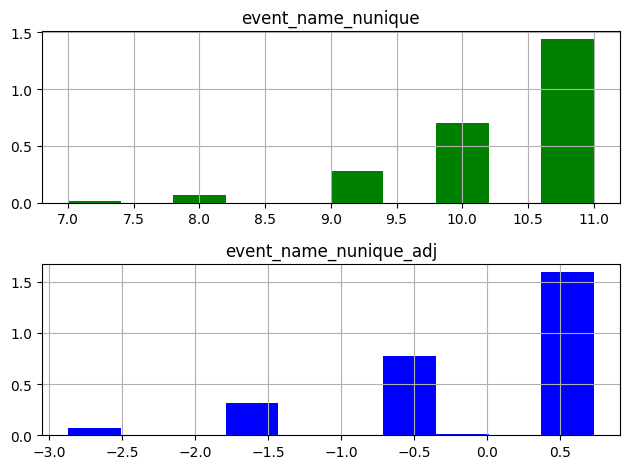

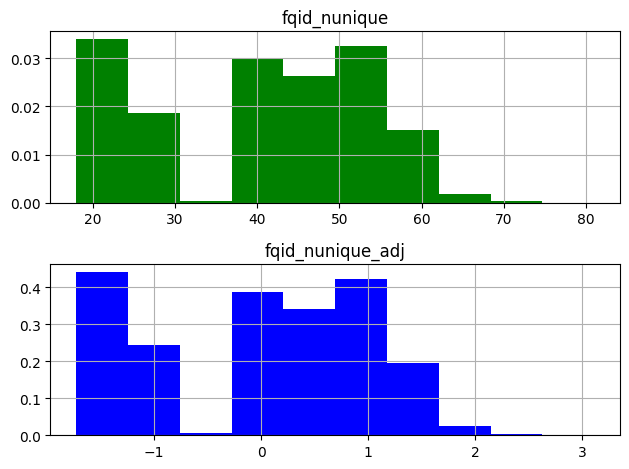

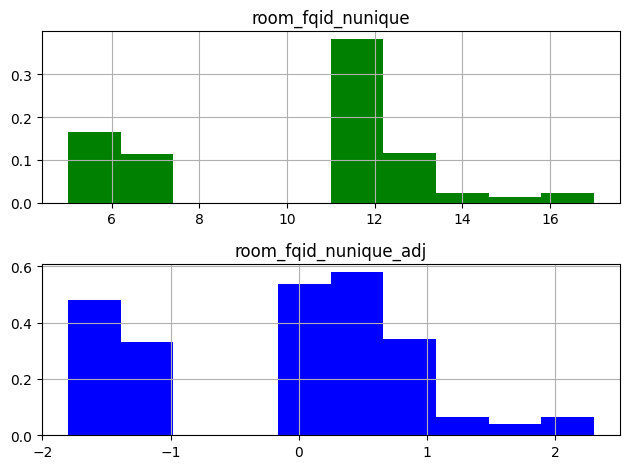

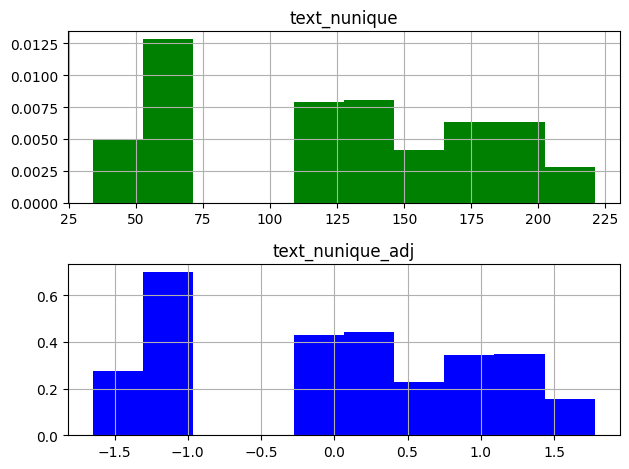

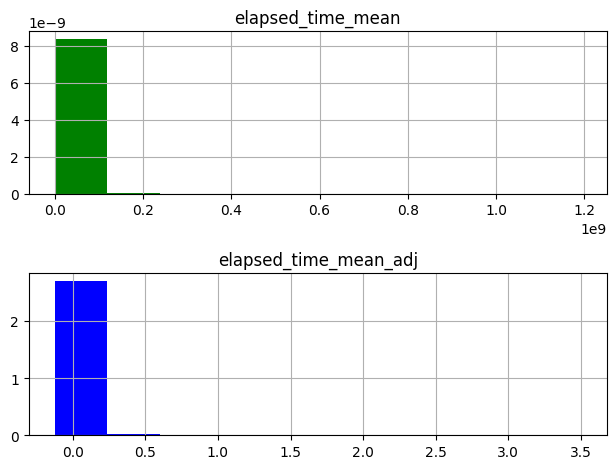

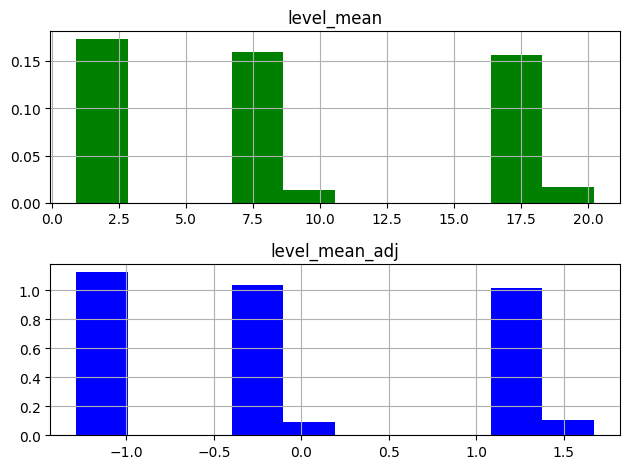

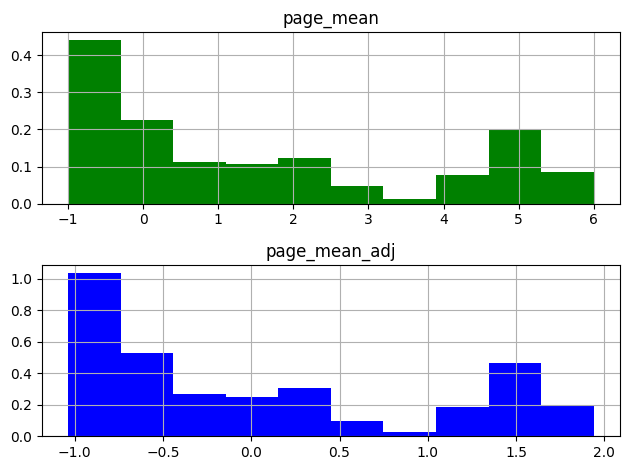

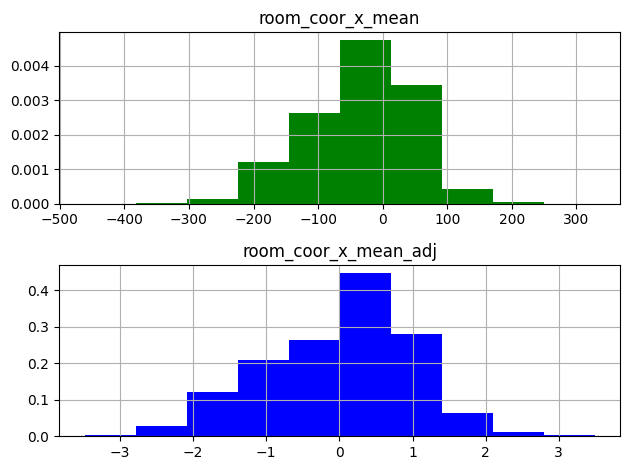

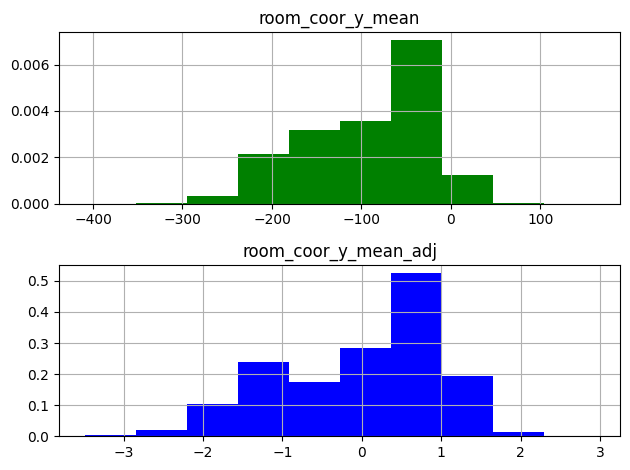

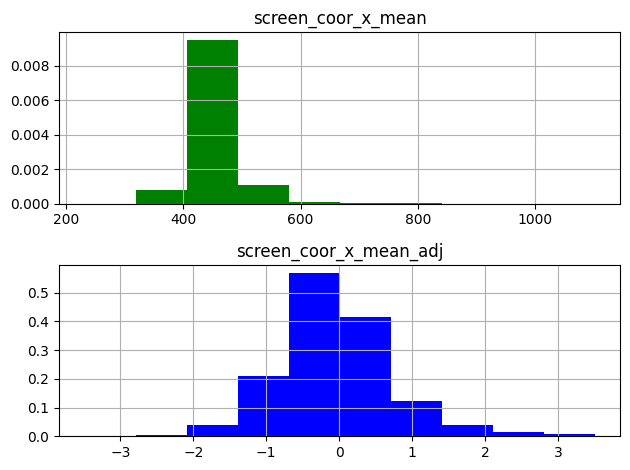

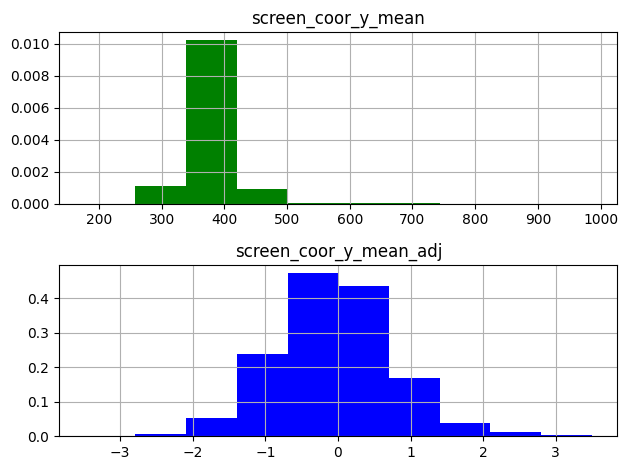

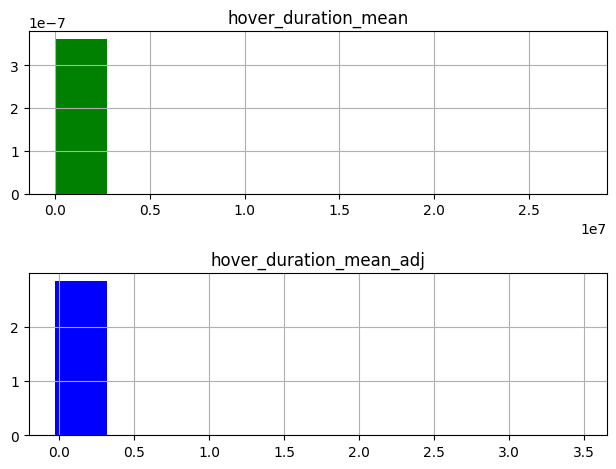

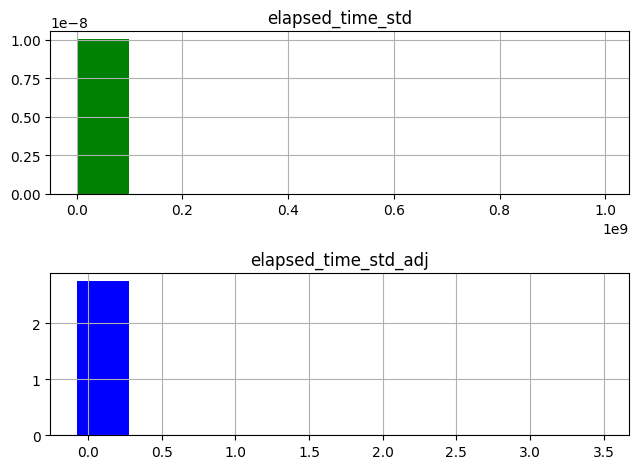

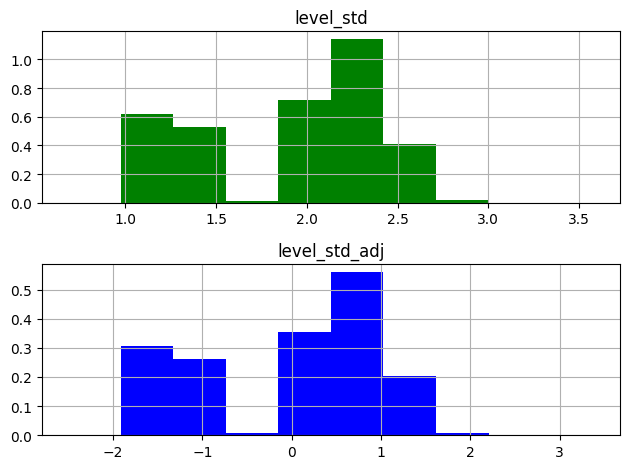

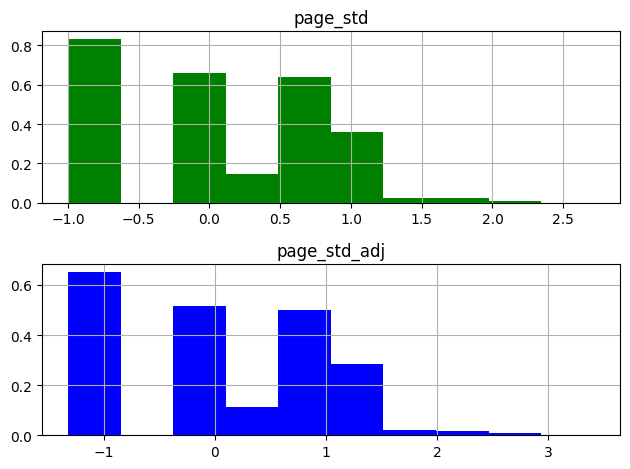

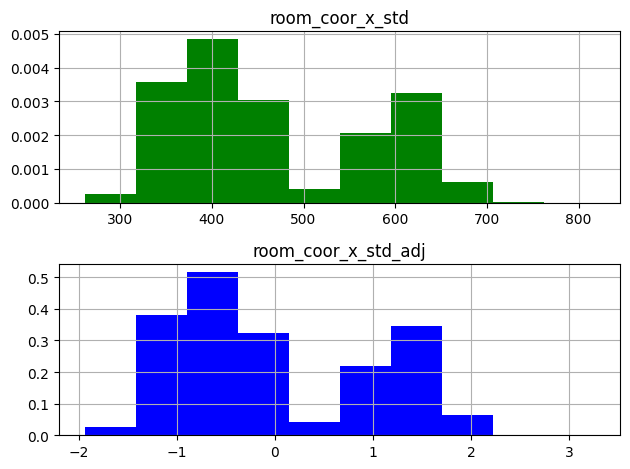

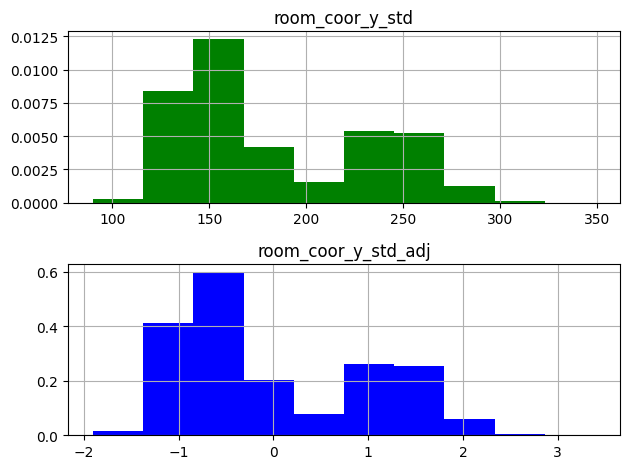

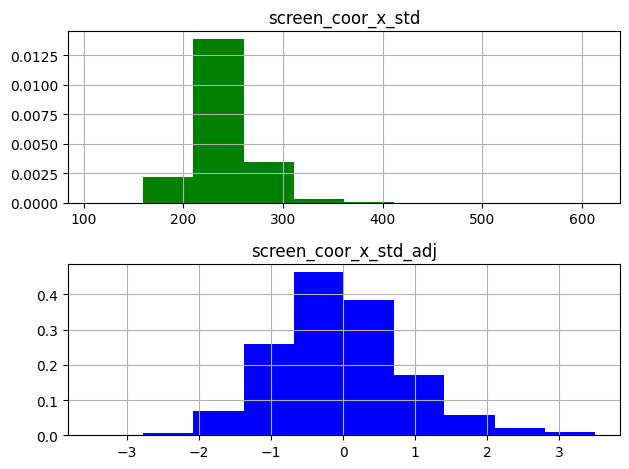

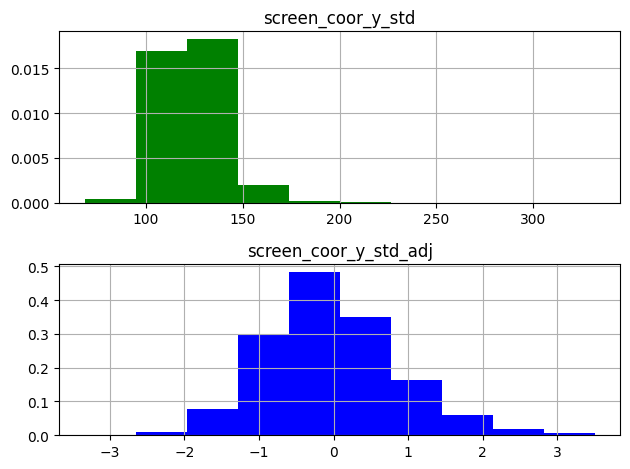

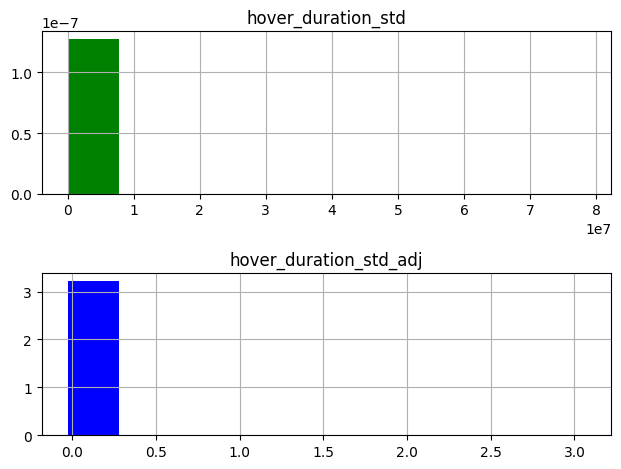

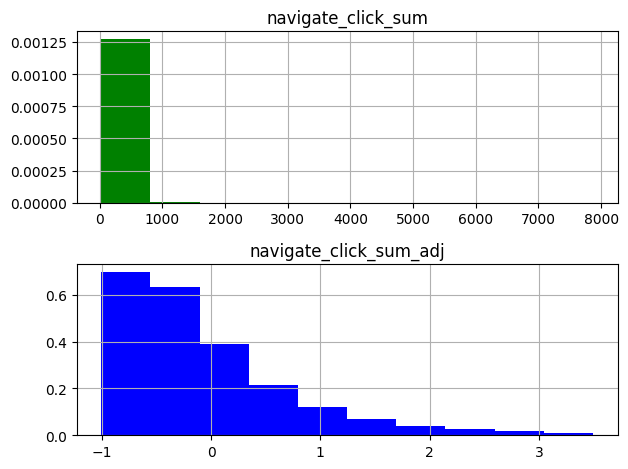

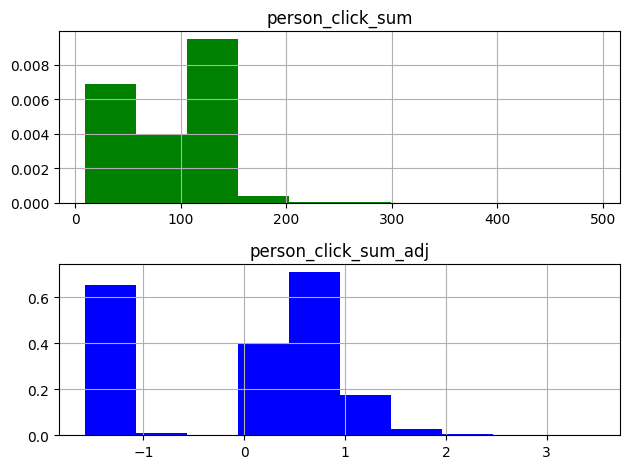

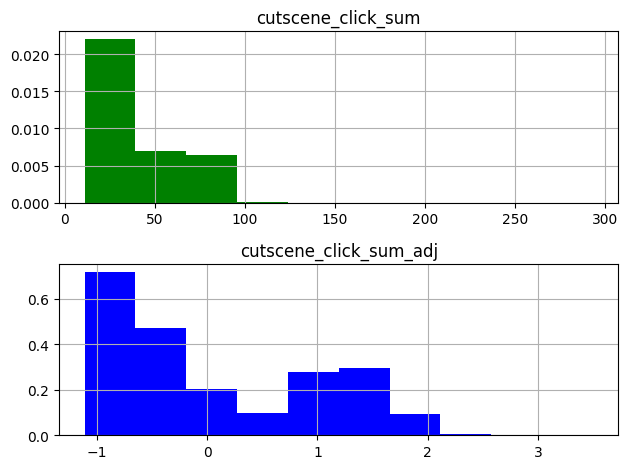

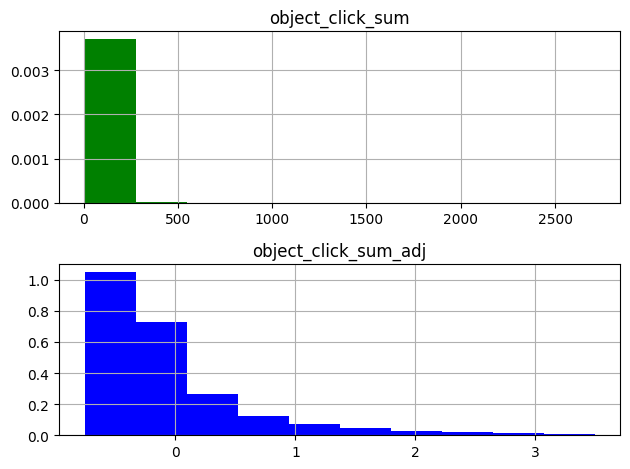

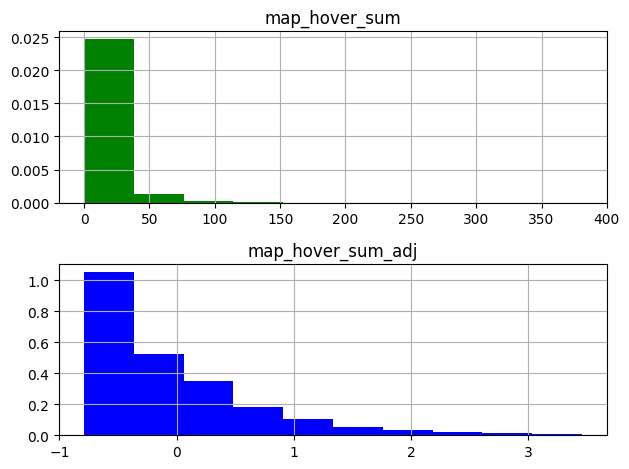

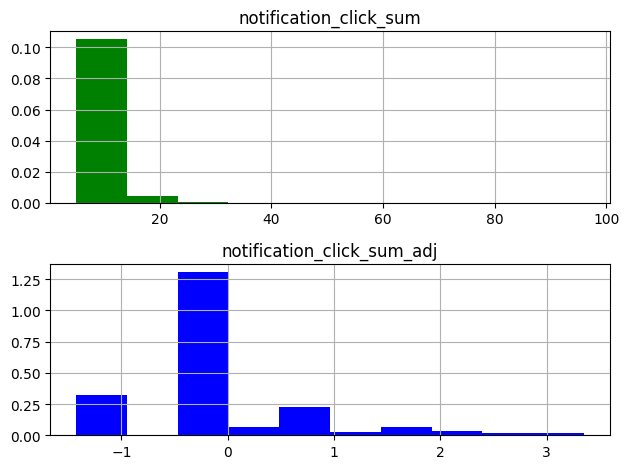

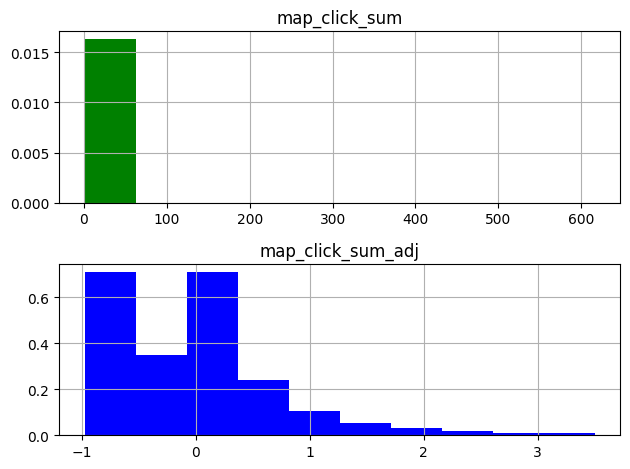

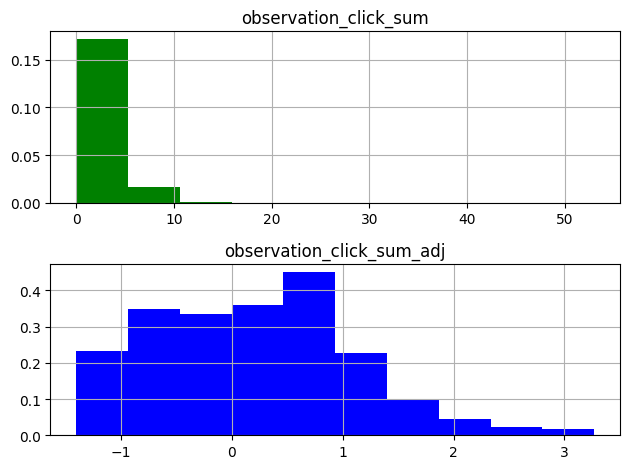

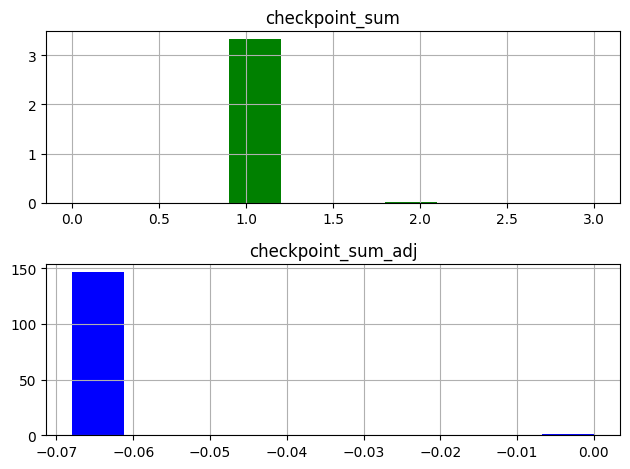

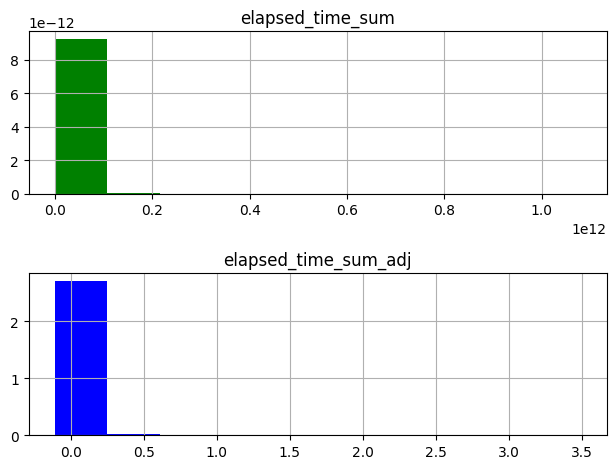

In [22]:
for name in names:
    fig, axs = plt.subplots(2)
    
    train_df_eng.drop(["level_group"],axis=1)[name].hist(density=True,color='green',ax=axs[0])
    axs[0].set_title(name)
    train_df_eng_adj_v2.drop(["level_group"],axis=1)[name].hist(density=True,color='b',ax=axs[1])
    axs[1].set_title(name+"_adj")
    fig.tight_layout()
    plt.show()
    plt.close()

### Continue using StandardScaler method to avoid outliers affecting scale as much as min/max

## Determine Multicollinearity with matrix and VIF

I plan to use Random Forest, XGBoost, and Logistic Regression, meaning multicollinearity is only really a problem for one of my models predicting powers. However, multicollinearity will still be handled, and for the tree style models, datasets accounted for and otherwise of multicollinearity can be used to test the differences.

In [23]:
train_df_adj = train_df_eng_adj_v2

In [159]:
train_df_adj.to_csv(PATH+"train_df_adj.csv")

In [24]:
train_df_adj.drop("level_group",axis=1).corr()

,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,screen_coor_x_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
event_name_nunique,1.000000,0.375456,0.340008,0.311309,0.080246,0.281407,0.499835,-0.215614,-0.118717,-0.028575,...,0.151466,0.310475,0.064664,0.150130,0.422798,0.174004,0.241466,0.350602,0.014013,0.085245
fqid_nunique,0.375456,1.000000,0.959901,0.949482,0.204999,0.926007,0.659011,-0.580128,-0.623668,0.235387,...,0.675652,0.900121,0.443000,0.398672,0.687243,0.443211,0.746545,0.653043,-0.002867,0.238202
room_fqid_nunique,0.340008,0.959901,1.000000,0.926988,0.192005,0.875140,0.615706,-0.506344,-0.547102,0.229976,...,0.663700,0.926451,0.332058,0.418677,0.675202,0.379916,0.796385,0.589249,-0.007681,0.226178
text_nunique,0.311309,0.949482,0.926988,1.000000,0.202697,0.947384,0.659237,-0.640523,-0.672505,0.218960,...,0.650886,0.923589,0.530308,0.308206,0.624767,0.388418,0.697940,0.586915,-0.014179,0.233528
elapsed_time_mean,0.080246,0.204999,0.192005,0.202697,1.000000,0.212527,0.166261,-0.158244,-0.174485,0.034062,...,0.158065,0.172953,0.160472,0.061555,0.153196,0.096823,0.155137,0.152171,0.076653,0.808317
level_mean,0.281407,0.926007,0.875140,0.947384,0.212527,1.000000,0.706075,-0.715974,-0.789572,0.217112,...,0.676362,0.800834,0.678228,0.211300,0.608327,0.357426,0.640804,0.594917,-0.019482,0.244780
page_mean,0.499835,0.659011,0.615706,0.659237,0.166261,0.706075,1.000000,-0.488902,-0.588095,0.160951,...,0.546848,0.544632,0.521913,0.197741,0.468128,0.260221,0.486474,0.470079,-0.007007,0.198949
room_coor_x_mean,-0.215614,-0.580128,-0.506344,-0.640523,-0.158244,-0.715974,-0.488902,1.000000,0.643475,0.307797,...,-0.456366,-0.446469,-0.687789,0.099295,-0.387223,-0.229840,-0.301463,-0.395207,0.010805,-0.178648
room_coor_y_mean,-0.118717,-0.623668,-0.547102,-0.672505,-0.174485,-0.789572,-0.588095,0.643475,1.000000,-0.182865,...,-0.600687,-0.450957,-0.781552,-0.004243,-0.398560,-0.208676,-0.381268,-0.457868,0.019809,-0.208534
screen_coor_x_mean,-0.028575,0.235387,0.229976,0.218960,0.034062,0.217112,0.160951,0.307797,-0.182865,1.000000,...,0.181377,0.207173,0.071167,0.165427,0.103671,0.135078,0.204486,0.167412,-0.000666,0.043120


 As we can see from the above, huge correlation matrix: many of the variables we have created have high correlation to one another. Rather than painstakingly comparing each of the 30 variables to one-another, we employ the VIF in order to see whether or not certain variables need to be removed in order to fix some level of multicollinearity.

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [26]:
train_vif = pd.DataFrame()
train_vif["feature"] = train_df_adj.drop("level_group",axis=1).columns

train_vif["VIF"] = [variance_inflation_factor(train_df_adj.drop("level_group",axis=1),i) for i in range(len(train_df_adj.drop("level_group",axis=1).columns))]

train_vif

,feature,VIF
0,event_name_nunique,2.213159
1,fqid_nunique,35.918932
2,room_fqid_nunique,24.396631
3,text_nunique,50.581874
4,elapsed_time_mean,3.203905
5,level_mean,70.600648
6,page_mean,5.127961
7,room_coor_x_mean,6.880195
8,room_coor_y_mean,22.066725
9,screen_coor_x_mean,3.025126


In [27]:
30-len(train_vif[train_vif["VIF"]<5])

13

Above is the number of variables would dropped should we continue with the VIF method of dropping highly correlated variables. Since the number is almost half of the total number of variables, other options will be investigated before coming back to VIF.

### Attempt at removing multicollinearity using PCA

In [28]:
from sklearn.decomposition import PCA

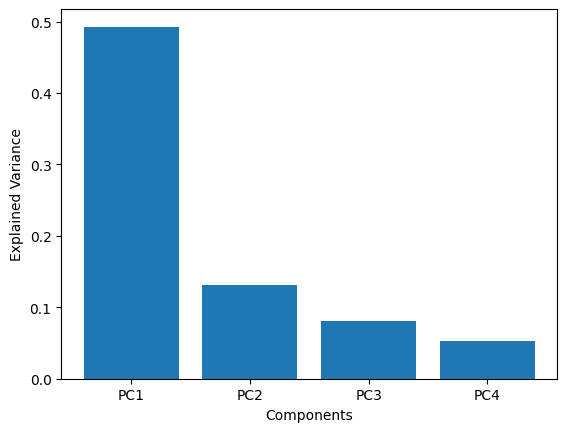

Total variance explained by the reduction: 0.758


In [29]:
NUM=4
pca = PCA(n_components=NUM)
pca.fit_transform(train_df_adj.drop("level_group", axis=1))

loading=pd.DataFrame(pca.components_.T,
                    columns=[f'PC{i}' for i in range(1,NUM+1)],
                    index=train_df_adj.drop("level_group",axis=1).columns)

plt.bar([f'PC{i}' for i in range(1,NUM+1)],pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

print(f"Total variance explained by the reduction: {sum(pca.explained_variance_ratio_):.3f}")

Value of 4 pca components here was chosen by "Kaiser-Guttman Rule": components based on eigenvalues greater than 1 should be retained and is considered an "above average" component.

In [30]:
print(pca.explained_variance_) ## this is the size of each value, after 4 it goes below 1

[10.11143819  2.69071723  1.66176167  1.09317613]


Below I have ordered the loading dataframe created of all the variables and their respective pca values, and created a col called "PCA" where the highest valued PC has been given, to easily see which PCs explained which variables.

In [31]:
loading["PCA"]=loading.idxmax(axis=1)
loading = loading.sort_values("PCA")
loading

,PC1,PC2,PC3,PC4,PCA
elapsed_time_sum,0.018646,-0.002562,-0.001573,0.001973,PC1
room_coor_y_std,0.253573,-0.257759,-0.147852,0.026532,PC1
room_coor_x_std,0.232706,-0.376457,-0.048123,-0.027238,PC1
cutscene_click_sum,0.208730,-0.397710,-0.017641,-0.045002,PC1
level_std,0.271169,0.208070,0.170384,-0.002536,PC1
elapsed_time_std,0.007762,0.001482,-0.003177,0.000700,PC1
map_hover_sum,0.158165,0.111579,0.009955,-0.046719,PC1
navigate_click_sum,0.183234,-0.015925,0.023580,0.138931,PC1
page_mean,0.244366,0.007597,-0.348260,-0.046874,PC1
level_mean,0.305990,-0.022128,0.100790,-0.020145,PC1


In [32]:
loading.corr()

C:\Users\TBWoo\AppData\Local\Temp\ipykernel_11516\4129189914.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loading.corr()


,PC1,PC2,PC3,PC4
PC1,1.000000,-0.172118,0.222645,-0.271676
PC2,-0.172118,1.000000,0.055796,-0.068084
PC3,0.222645,0.055796,1.000000,0.088070
PC4,-0.271676,-0.068084,0.088070,1.000000


In [33]:
train_df_pca = pd.DataFrame(pca.transform(train_df_adj.drop("level_group", axis=1)))
train_df_pca = train_df_pca.set_axis(list(train_df_adj.index))
train_df_pca.index.name = 'session_id'
train_df_pca = pd.concat([train_df_adj.level_group,train_df_pca],axis=1)
train_df_pca.columns = ["level_group", "PC1", "PC2", "PC3", "PC4"]

In [34]:
train_df_pca

,level_group,PC1,PC2,PC3,PC4
session_id,,,,,
20090312431273200,0-4,-3.444479,-0.759258,1.071873,-0.281788
20090312431273200,13-22,2.256776,-1.535602,2.588473,-0.717464
20090312431273200,5-12,-1.563815,1.599263,1.945036,0.056227
20090312433251036,0-4,-3.284032,-1.634323,-1.065006,-2.101933
20090312433251036,13-22,4.212048,0.854277,-1.067348,0.707431
...,...,...,...,...,...
22100219442786200,13-22,4.097262,-1.645516,-1.323840,-0.190828
22100219442786200,5-12,-0.408099,1.211010,-1.049437,0.281216
22100221145014656,0-4,-2.753571,0.120292,-1.513947,-0.892052


## Formalize Targets with inputs so models can be trained

In [37]:
targets.head()

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [125]:
key_dict = {'0-4': [1,2,3],'5-12':[4,5,6,7,8,9,10,11,12,13],'13-22':[14,15,16,17,18]}

In [36]:
from xgboost import XGBClassifier

In [119]:
key_dict["1-4"]

[1, 2, 3]

In [120]:
[int(targets[(targets["session"] == 20090312431273200) & (targets["q"] == key)]["correct"]) for key in key_dict["1-4"]]

[1, 1, 1]

In [126]:
for (session,keyd) in zip(list(train_df_pca.index),list(train_df_pca.level_group)):
    this = [int(targets[(targets["session"] == session) & (targets["q"] == key)]["correct"]) for key in key_dict[keyd]] 

KeyboardInterrupt: 

In [129]:
this = [[int(targets[(targets["session"] == session) & (targets["q"] == key)]["correct"]) for key in key_dict[keyd]] for (session,keyd) in zip(list(train_df_pca.index),list(train_df_pca.level_group))]

In [130]:
this

[[1, 1, 1],
 [1, 1, 0, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [0, 1, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
 [1, 1, 1],
 [1, 0, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1],
 [1, 0, 1, 1, 1],
 [1, 1, 0, 1, 1, 1, 0, 0, 1, 0],
 [1, 1, 1],
 [0, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
 [1, 1, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
 [1, 1, 1],
 [1, 1, 1, 0, 1],
 [0, 0, 1, 1, 0, 0, 1, 1, 1, 0],
 [0, 1, 1],
 [1, 1, 1, 0, 1],
 [0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
 [1, 1, 1],
 [1, 0, 0, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1],
 [1, 1, 1, 1, 1],
 [1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
 [0, 1, 1],
 [1, 1, 1, 1, 1],
 [1, 0, 0, 1, 1, 1, 1, 0, 1, 1],
 [1, 1, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
 [1, 1, 1],
 [1, 1, 0, 1, 1],
 [1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
 [1, 1, 1],
 [1, 1, 1, 0, 1],
 [1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
 [0, 1, 1],
 [0, 0, 0, 0, 1],
 [1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [1, 1, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 1, 1, 1, 1, 0, 0,